### Imports

In [2]:
from matplotlib import pyplot as plt
import xml.etree.ElementTree as et
import numpy as np
import glob

### File selection

In [3]:
#this just allows easy folder selection so you don't have to copy the name from the file browser

folders = glob.glob("*_map")
for i in range(0, len(folders)):
    print(str(i) + "\t" + str(folders[i]))

In [15]:
fp1 = r"C:\Users\elf\Documents\GitHub\xrf-thickness-studies\scan time studies\20230711_CVD_3158_scantime\20230711_CVD_3158_60s 1.spx"

### Function definitions

In [16]:
def getIntensity(r, z):
    """z can be an int or string representing atomic number of element. (not a float)
    returns net intensity of element z"""
    result = r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTResult']/RoiResults/Atom[.='"
                         + str(z)
                         + "']/..")
    if len(result) == 0:
        raise Exception("Could not find intensity of element " + str(z))
    else:
        print(result[0].findall("./Description")[0].text, "Peak")
        return int(result[0].findall("./NetCounts")[0].text)

In [17]:
def getEnergyAxis(r):
    num_channels = int(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "ChannelCount")[0].text)
    chan_to_en_m = float(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "CalibLin")[0].text)
    chan_to_en_b = float(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "CalibAbs")[0].text)
    return np.arange(0, 4096)*chan_to_en_m + chan_to_en_b

In [18]:
def getRawCountsData(r):
    data = r.findall("./ClassInstance[@Type='TRTSpectrum']/Channels")[0].text.split(",")
    #for i in range(0, len(data)):
    #    data[i] = int(data[i])

    #numpy can convert str to int
    return np.array(data, dtype=int)

In [19]:
def getBackgroundData(r):
    background = r.findall("./ClassInstance[@Type='TRTSpectrum']/ChildClassInstances/ClassInstance"
          "[@Type='TRTXRFBulkQuantificationResults']/TRTSpectrumQuantificationResults/"
          "ClassInstance[@Type='TRTSpectrumList']/ChildClassInstances/ClassInstance"
          "[@Type='TRTSpectrum']/Channels")[0].text.split(",")
    #for i in range(0, len(background)):
    #    background[i] = float(background[i])

    #numpy can convert str to float
    return np.array(background, dtype=float)

### Data reading
modify this cell to change which data is read

In [20]:
dat = {
    "d1_counts": getRawCountsData(et.parse(fp1).getroot()),
    "energy": getEnergyAxis(et.parse(fp1).getroot())}

### Plotting
modify this cell to change how the data is plotted

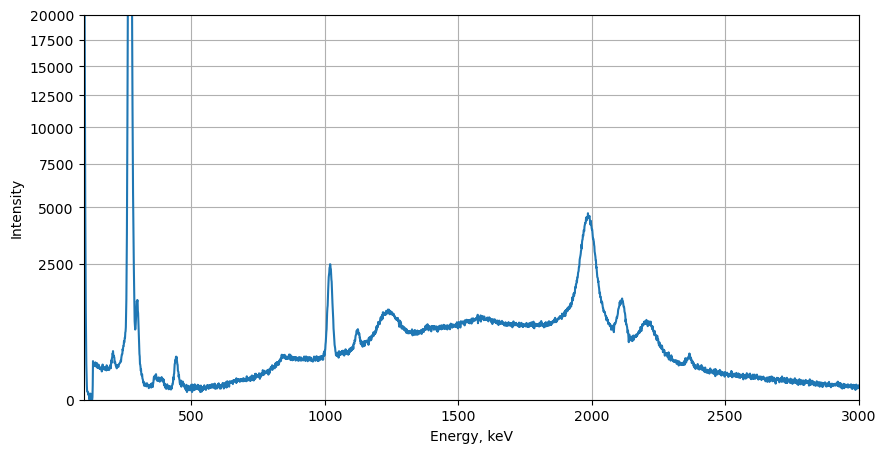

In [29]:
upper_ylim = np.max(dat["d1_counts"][150:]) + 5000

f, ax = plt.subplots(figsize=(10,5))
ax.plot(dat["d1_counts"], label = "detector 1")
#ax.plot(dat["energy"], dat["d2_counts"], label = "detector 2")
ax.set_xlabel("Energy, keV")
ax.set_ylabel("Intensity")
#ax.set_title(sample_name + " XRF spectrum, " + str(spec))
#ax.legend()

#square root scale
ax.set_yscale("function", functions=(np.sqrt, lambda x: x*x))

ax.axis([97, 3000, 0, 20000])
ax.grid(True)
plt.show()